## Decision Trees

In this homework, you will fill in some details for an implementation of decision trees, and the creation of an ensemble of decision trees using AdaBoost.

We will be applying these models to a spam classification dataset consisting of 3000 training examples with 57 continuous-valued features. These features include the frequencies of certain words (e.g., credit, money, free), characters (e.g., $ and !) as well as a few features concerning the usage of capital letters.

In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from itertools import accumulate, groupby
from operator import itemgetter
from collections import deque
import heapq


def load_data(split):
    if split in ("train", "val"):
        with open(f"data/{split}.pkl", "rb") as f:
            return pickle.load(f)
    else:
        with open("data/x_test.pkl", "rb") as f:
            return pickle.load(f)


def make_submission(predictions, name):
    with open(f"submission_{name}.csv", "w") as f:
        f.write("id,prediction\n")
        for i, pred in enumerate(predictions):
            f.write(f'"{i}","{int(pred)}"\n')

In [8]:
class DecisionNode:
    """
    Class for representing a node in a decision tree
    """

    def __init__(self, parent):
        # Fields used if the node is an internal node
        self.parent = parent
        self.left = None
        self.right = None

        self.feature = None  # Index of feature to split on
        self.threshold = None  # Threshold to split on

        # Fields used if the node is a leaf node
        self.leaf = False
        self.label = None

        # Bookkeeping fields for pruning
        self.indices = None
        self.train_error = 0
        self.val_error = 0

    def __lt__(self, other):
        # dummy function to make heapq accept these
        return True

### Splitting Criterion
The folllowing are two functions which are used to decide what feature and threshold to use for splitting a leaf when building our trees. The weights they take as arguments are either a count of examples in the single tree case, or the sum of the weights of the examples in the boosting case.

## <font color=blue>Code 1</font>

In [9]:
def gini_index(total_weight, positive_weight):
    """
    Compute the Gini index for a leaf
        total_weight: Total weight of the examples in the leaf (or number of examples for unweighted data)
        positive_weight: The amount of weight on the positive examples in the leaf
    """
    negative_weight = total_weight - positive_weight

    return (positive_weight/total_weight)*(1-positive_weight/total_weight)+(negative_weight/total_weight)*(1-negative_weight/total_weight)


def compute_impurity(left_weight, left_impurity, right_weight, right_impurity):
    """
    Compute the impurity of a potential leaf split
       left_weight: The total weight of all examples to the left of the candidate threshold
       left_impurity: The impurity that the new left leaf will have if the split is made
       right_weight and right_impurity are defined analogously
    """
    
    return left_weight*left_impurity+right_weight*right_impurity

In [10]:
def find_threshold(data, feature_id):
    """
    Find the best threshold for a given feature (using Gini index of potential children), and return the threshold and score
    `data` is a list of tuples of the form ((features, label), weight)
    """

    # Sort the data by the value of the feature we're checking
    def feature_key(elem):
        # Throw away label and weight
        (features, _), _ = elem
        return features[feature_id]

    data.sort(key=feature_key)

    # group the data by the feature (in case several examples have the same value)
    # For example, if our data was
    # `((1, 2, 3), 0), ((4, 2, 1), 1), ((5, 4, 3), 1)`,
    # grouping by feature 1 (0-indexed) would give:
    # [ ((1,2,3), 0), ((4, 2, 1), 1) ], [ ((5, 4, 3), 1) ]
    grouped = list(list(group) for _, group in groupby(data, feature_key))

    # Get the total weight on each group (if examples are unweighted, the total weight is just the number of examples)
    group_weights = (sum(weight for _, weight in group) for group in grouped)

    # cumulative_weights[i] = total number of examples up to and including group `i`
    cumulative_weights = list(accumulate(group_weights))

    # Get the total weight so we can normalize the weights in this node to get a probability distribution
    total_weight = cumulative_weights[-1]

    # Get the weight on positive examples in each group
    positive_weights = (
        sum(weight * (label == 1) for ((_, label), weight) in group)
        for group in grouped
    )
    # cumulative_positive_weight[i] = total weight on positive examples up to and including group i
    cumulative_positive_weight = list(accumulate(positive_weights))

    # Probability mass of all positive examples at this node
    positive_weight = cumulative_positive_weight[-1]

    if not (
        0 < positive_weight < total_weight and len(grouped) > 1
    ):  # If leaf is pure or all examples agree on this feature, return
        # Give this feature an infinitely bad score if no split is possible
        return float("inf"), None

    best_impurity = float("inf")
    best_threshold = None
    # Consider each possible split point (for the boundary, use xi <= threshold and xi > threshold)
    # left_total is the number of examples with a feature value less than or equal to candidate threshold
    # left_positive is the number of those examples which are in the positive class

    # Skip last group since splitting after it would put all the data in one leaf
    for group_num, (left_total, left_positive) in enumerate(
        zip(cumulative_weights[:-1], cumulative_positive_weight[:-1])
    ):
        # Get the weight of positive and negative examples of each child

        right_total = total_weight - left_total
        right_positive = positive_weight - left_positive

        # The considered threshold will split the data into two groups of size left_total and right_total
        # These groups will contain left_positive and right_positive positive examples
        # Now we should compute the improvement we'll get from this split
        left_gini_index = gini_index(left_total, left_positive)
        right_gini_index = gini_index(right_total, right_positive)

        impurity = compute_impurity(
            left_total, left_gini_index, right_total, right_gini_index
        )

        if impurity < best_impurity:
            best_impurity = impurity
            current_group_val = grouped[group_num][0][0][0][feature_id]
            next_group_val = grouped[group_num + 1][0][0][0][feature_id]

            # Get the value of the threshold for the group of examples we're currently considering
            best_threshold = (current_group_val + next_group_val) / 2

    return best_impurity, best_threshold

In [11]:
def split_indices(full_data, node_indices, feature, threshold):
    """
    Split a node's assigned examples based on the given feature and threshold
    """
    left_indices = []
    right_indices = []
    for i in node_indices:
        features, _ = full_data[i]
        if features[feature] <= threshold:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

In [12]:
def fit_unpruned_tree(data, max_depth=10, min_split_size=10, weights=None):
    """
    Builds and returns a full decision tree on the data
       data: List of (example, label) pairs
       max_depth: Limit to depth of tree
       min_split_size: Minimum number of data points at which to still consider splitting a leaf
       weights: a list of weights the same length as data
    """

    if weights is None:
        weights = np.ones(len(data))

    n_features = len(data[0][0])

    root = DecisionNode(None)

    # We'll build the tree breadth-first
    node_queue = deque()
    node_queue.append(
        (
            list(range(len(data))),  # The root node will process every example
            root,
            1,  # The root node is at depth 1
        )
    )

    # The queue holds the indices of the training data each node is responsible for, along with the node
    # Indices are used to avoid duplicating the full dataset
    while node_queue:
        indices, node, depth = node_queue.popleft()
        # At this point, the node does not have a feature or threshold assigned
        node_data = [(data[i], weights[i]) for i in indices]

        total_node_weight = sum(w for _, w in node_data)

        # Compute the majority label
        node.label = (
            1
            if sum(weight * (label == 1) for (_, label), weight in node_data)
            > total_node_weight / 2
            else -1
        )
        # Keep track of how many errors this node makes for pruning later
        node.errors = sum(l != node.label for (_, l), _ in node_data)
        assert not (node.errors > 0 and len(node_data) == 1)

        # If at max depth, stop branching
        if depth == max_depth or len(node_data) <= min_split_size:
            node.leaf = True
        # Otherwise consider each possible splitting criterion
        else:
            impurities_and_thresholds = (
                (find_threshold(node_data, feat_id), feat_id)
                for feat_id in range(n_features)
            )
            # Select the threshold and feature which give the lowest impurity score of the children
            (result_impurity, threshold), best_feature = min(impurities_and_thresholds)

            if result_impurity != float("inf"):
                # Only make children for this node if some feature gave a meaningful split

                # We can now set our node's threshold and feature
                node.feature = best_feature
                node.threshold = threshold

                left_child = DecisionNode(node)
                right_child = DecisionNode(node)

                # Attach the newly created children to this node
                node.left = left_child
                node.right = right_child
                # Used for keeping track for pruning

                # Partition the indices based on the threshold
                left_indices, right_indices = split_indices(
                    data, indices, best_feature, threshold
                )

                # Put the children on the queue for processing
                node_queue.append((left_indices, left_child, depth + 1))
                node_queue.append((right_indices, right_child, depth + 1))

            else:
                node.leaf = True

    return root

### Tree Pruning
## <font color=blue>Code 2</font>

In [13]:
def compute_error_change(parent_node):
    """
    Compute how much collapsing a node that has two leaf children would increase the 0-1 error of our tree
    """
    left_error = parent_node.left.train_error
    right_error = parent_node.right.train_error
    parent_error = (
        parent_node.train_error
    )  # This is the number of errors this node would make were it a leaf

    return parent_error-left_error-right_error



In [14]:
def prune_tree(root, train_data, val_data):
    """
    This function computes a sequence to collapse internal nodes in based on
    the change in the weighted training error.

    The validation data is used to select the best one of these trees

      root: A DecisionNode with no parent
      train_data: A list of (features, label) tuples
      val_data: A list of (features, label) tuples
    """

    # If the tree is just one node, do nothing
    if root.leaf:
        return

    # Once again we want to work with indices instead of copying the data many times
    train_indices = list(range(len(train_data)))
    val_indices = list(range(len(val_data)))

    # This queue is used to perform a breadth-first traversal of our tree
    bf_queue = deque()
    bf_queue.append((root, train_indices, val_indices))

    single_leaf_parents = set()
    double_leaf_parents = set()

    total_train_error = 0
    total_val_error = 0
    n_nodes = 0
    while bf_queue:
        node, node_train, node_val = bf_queue.popleft()
        n_nodes += 1

        # As we traverse the tree, we can keep track of the training and validation errors that
        # would be incurred by having each node as a leaf

        # weighted 0-1 training error at this node
        node.train_error = sum(train_data[i][1] != node.label for i in node_train)

        # 0-1 validation error at this node
        node.val_error = sum(val_data[i][1] != node.label for i in node_val)

        if node.leaf:
            total_train_error += node.train_error
            total_val_error += node.val_error
            continue

        # Partition both the training and validation sets according to this node's rule
        left_train = [
            i for i in node_train if train_data[i][0][node.feature] <= node.threshold
        ]
        right_train = [
            i for i in node_train if train_data[i][0][node.feature] > node.threshold
        ]

        left_val = [
            i for i in node_val if val_data[i][0][node.feature] <= node.threshold
        ]
        right_val = [
            i for i in node_val if val_data[i][0][node.feature] > node.threshold
        ]

        # Add the children of non-leaf nodes to the queue to be processed
        bf_queue.append((node.left, left_train, left_val))
        bf_queue.append((node.right, right_train, right_val))

        # Keep track of how many leaves each node has as children, since we'll only be able to prune
        # those that have two children
        if node.left.leaf and node.right.leaf:
            double_leaf_parents.add(node)
        elif node.left.leaf or node.right.leaf:
            single_leaf_parents.add(node)

    # We'll use the python heapq module to maintain a priority queue of internal nodes to "collapse"
    # (We won't actually collapse them in the tree, just figure out the order we would collapse them in)
    min_heap = []
    # Consider all internal nodes which are the parents of two leaves as candidates for pruning
    for node in double_leaf_parents:
        collapse_error_increase = compute_error_change(node)
        heapq.heappush(min_heap, (collapse_error_increase, node))

    # Using our priority queue, we can compute the order that we will collapse nodes in
    # We don't actually collapse them at this point, but we can still compute the order using the errors
    # we computed during our earlier traversal
    current_val_error = total_val_error
    collapse_sequence = []
    while min_heap:
        # Get the node which has two leaves as children that has the least
        _, collapse_node = heapq.heappop(min_heap)

        current_val_error += (
            collapse_node.val_error
            - collapse_node.left.val_error
            - collapse_node.right.val_error
        )
        collapse_sequence.append((current_val_error, collapse_node))

        # The parent of the node we just collapsed may now be a candidate to be collapsed,
        # so update its number of children
        if collapse_node.parent in single_leaf_parents:
            single_leaf_parents.remove(collapse_node.parent)

            train_error_increase = compute_error_change(collapse_node.parent)
            heapq.heappush(min_heap, (train_error_increase, collapse_node.parent))
        elif (
            collapse_node.parent
        ):  # Don't do anything after we collapse the root, which has `None` for its parent
            single_leaf_parents.add(collapse_node.parent)

    # Get the minimum validation error of any tree in our collapse sequence
    min_error, _ = min(collapse_sequence)

    # If the validation error of the unpruned tree is the best, no need to do anything else
    if total_val_error <= min_error:
        return

    # Now lets actually collapse the nodes in our tree
    for error, node in collapse_sequence:
        # Remove references to the children so they get garbage collected
        node.left.parent = None
        node.left = None

        node.right.parent = None
        node.right = None
        node.leaf = True

        node.threshold = None
        node.feature = None

        # min_error was selected from this list, so this comparison is guaranteed to trigger at some point
        if error == min_error:
            break

In [15]:
# Some helper functions for getting the output of a decision tree on data
def apply_tree(root, features):
    """
    Apply the tree to an example to get a prediction
    """
    node = root
    while not node.leaf:
        node = node.left if features[node.feature] <= node.threshold else node.right
    return node.label


def evaluate_tree(root, data):
    num_correct = sum(label == apply_tree(root, features) for features, label in data)
    return num_correct / len(data)


def label_data(root, unlabeled_data):
    return [apply_tree(root, features) for features in unlabeled_data]

In [16]:
def fit_single_tree(train_data, val_data):
    """
    Run a grid search over the max_depth and min_split_size hyperparameter
    max_depth is a limit on how deep our trees can be
    min_split_size disallows splitting leaves with this many or fewer training examples in them
    """
    best_tree = None
    best_accuracy = 0
    for max_depth in np.logspace(1, 5, 6, base=2).astype(int):
        for min_split_size in np.logspace(0, 4, 5, base=2).astype(int):
            root_node = fit_unpruned_tree(
                train_data, max_depth=max_depth, min_split_size=min_split_size
            )

            # This will always be non-zero because there are two pairs of training examples having the exact same features but different labels
            pre_prune_train_accuracy = evaluate_tree(root_node, train_data)

            prune_tree(root_node, train_data, val_data)
            val_accuracy = evaluate_tree(root_node, val_data)
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_tree = root_node

            print(
                f"Max Depth: {max_depth} Min Split Size: {min_split_size}"
                f" Train Accuracy: {evaluate_tree(root_node, train_data):0.04f}"
                f" Train Accuracy (pre-pruning): {pre_prune_train_accuracy:0.04f}"
                f" Val Accuracy: {val_accuracy:0.04f}"
            )

    return best_tree

### Toy Example

Now that we've impemented our decision tree algorithm, we can apply it to a simple toy example.

In [17]:
def make_toy_dataset():
    means = [(-2, -2), (2, -2), (2, 2), (-2, 2)]
    data = []
    for _ in range(1000):
        index = np.random.randint(0, 4)
        data.append((np.random.randn(2) + means[index], 1 if index % 2 else -1))

    n_train = 500
    toy_train = data[:n_train]
    toy_val = data[n_train:]
    return toy_train, toy_val

Lets look at the effect of tree size and pruning on the learned classifiers

In [18]:
def visualize_classifier(tree, data, axes):
    xs = [feat[0] for feat, _ in data]
    ys = [feat[1] for feat, _ in data]
    color = [label for _, label in data]
    xmin = min(xs)
    xmax = max(xs)
    ymin = min(ys)
    ymax = max(ys)

    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200))

    predictions = np.array(
        [
            [apply_tree(tree, pair) for pair in row]
            for row in np.concatenate(
                (np.expand_dims(xx, 2), np.expand_dims(yy, 2)), axis=2
            )
        ]
    )

    axes.contourf(xx, yy, predictions, cmap="RdBu")
    axes.scatter(xs, ys, c=color, cmap="RdBu")
    x = 3

In the following plots, the training set is plotted with color indicating the class. The background color is the prediction of the classifier on that region (when the background is a single color, it means that the classifier predicted only a single class on that region).

The overfitting happening is quite clear once we start increasing the depth, and pruning using the validation set helps quite a bit.

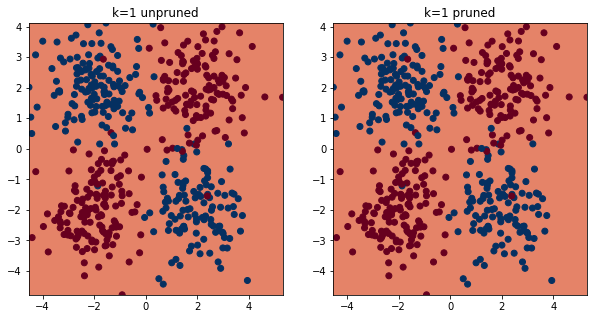

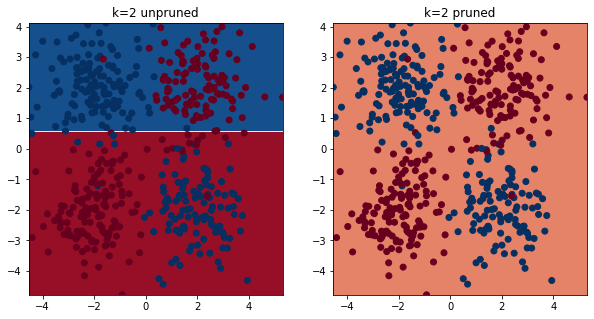

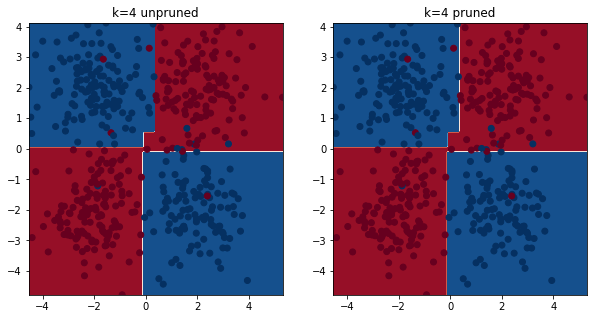

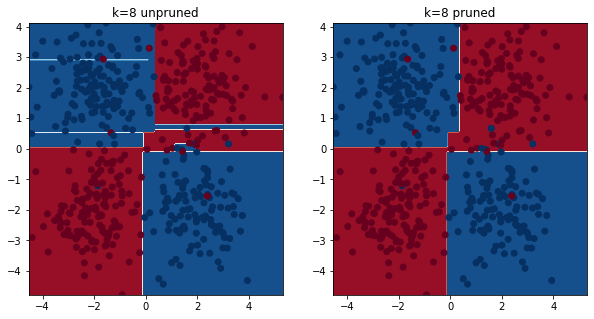

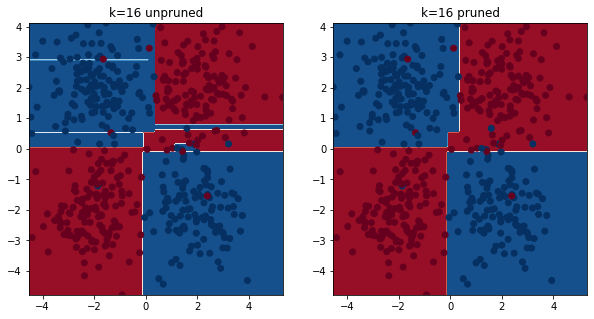

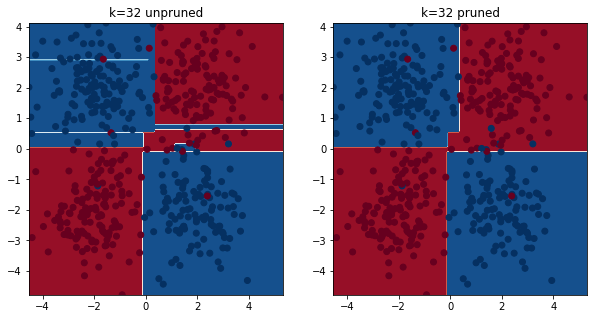

In [17]:
toy_train, toy_val = make_toy_dataset()
trees = {
    k: fit_unpruned_tree(toy_train, max_depth=k, min_split_size=1)
    for k in (1, 2, 4, 8, 16, 32)
}
for k, tree in trees.items():
    fig, (left, right) = plt.subplots(ncols=2, figsize=(10, 5))
    visualize_classifier(tree, toy_train, axes=left)

    prune_tree(tree, toy_train, toy_val)
    visualize_classifier(tree, toy_train, axes=right)
    left.set_title(f"k={k} unpruned")
    right.set_title(f"k={k} pruned")

### Real dataset

In [19]:
train_data = load_data("train")
val_data = load_data("val")
test_x = load_data("test")

### Experiment 1: Decision Tree

In [19]:
root_node = fit_single_tree(train_data, val_data)
labels = label_data(root_node, test_x)
# This will create a file called "submission_single.csv" for you to submit to Kaggle
make_submission(labels, name="single")

Max Depth: 2 Min Split Size: 1 Train Accuracy: 0.7967 Train Accuracy (pre-pruning): 0.7967 Val Accuracy: 0.7946
Max Depth: 2 Min Split Size: 2 Train Accuracy: 0.7967 Train Accuracy (pre-pruning): 0.7967 Val Accuracy: 0.7946
Max Depth: 2 Min Split Size: 4 Train Accuracy: 0.7967 Train Accuracy (pre-pruning): 0.7967 Val Accuracy: 0.7946
Max Depth: 2 Min Split Size: 8 Train Accuracy: 0.7967 Train Accuracy (pre-pruning): 0.7967 Val Accuracy: 0.7946
Max Depth: 2 Min Split Size: 16 Train Accuracy: 0.7967 Train Accuracy (pre-pruning): 0.7967 Val Accuracy: 0.7946
Max Depth: 3 Min Split Size: 1 Train Accuracy: 0.8540 Train Accuracy (pre-pruning): 0.8540 Val Accuracy: 0.8459
Max Depth: 3 Min Split Size: 2 Train Accuracy: 0.8540 Train Accuracy (pre-pruning): 0.8540 Val Accuracy: 0.8459
Max Depth: 3 Min Split Size: 4 Train Accuracy: 0.8540 Train Accuracy (pre-pruning): 0.8540 Val Accuracy: 0.8459
Max Depth: 3 Min Split Size: 8 Train Accuracy: 0.8540 Train Accuracy (pre-pruning): 0.8540 Val Accuracy

## <font color=red>Question 1</font>
Report the result of your **best model** for experiment 1
- hyperparamter setting
- train accuracy
- validation accuracy
- test accuracy on Kaggle public leaderboard (you can check Kaggle private leaderboard after the competition deadline)



## <font color=red>Answer</font>
My best model (in terms of val accuracy) had:
- Max Depth of 32
- Min Split of 1
- Training Accuracy of 0.9917
- Validation Accuracy of 0.9344
- Kaggle Accuracy of 0.91111

----
## Ensemble

In [20]:
# Helper functions for running ensembles on data
def apply_ensemble(classifiers, features):
    return np.sign(
        sum(alpha * apply_tree(tree, features) for tree, alpha in classifiers)
    )


def evaluate_ensemble(classifiers, data):
    num_correct = sum(
        label == apply_ensemble(classifiers, features) for features, label in data
    )
    return num_correct / len(data)


def label_ensemble(classifiers, unlabeled_data):
    return [apply_ensemble(classifiers, feat) for feat in unlabeled_data]

## <font color=blue>Code 3</font>

In [128]:
def adaboost(
    train_data, val_data, max_steps=100, max_depth=4, min_split_size=10, patience=20
):
    """
    Run adaboost with unpruned shallow trees as the weak learners
    Validation set is used for early stopping (halt after the validation accuracy hasn't increased for some number of steps)
    """
    weights = np.full(len(train_data), 1 / len(train_data))
    classifiers = []

    best_t = -1
    best_val_accuracy = 0
    last_improvement = 0

    # Incrementally keep the ensemble predictions to save computation
    current_train_scores = np.zeros(len(train_data))
    current_val_scores = np.zeros(len(val_data))

    for t in range(max_steps):
        tree = fit_unpruned_tree(
            train_data,
            max_depth=max_depth,
            min_split_size=min_split_size,
            weights=weights,
        )
        predictions = np.array(
            [apply_tree(tree, features) for features, _ in train_data]
        )
        
        labels = np.array(train_data)[:,-1].astype(np.int32, copy=False)
        weighted_error = np.sum(weights[predictions!=labels])# Add your code here for computing the weighted error of the newest weak classifier
        alpha = (np.log((1-weighted_error)/weighted_error))/2.0 # Add your code here to compute the alpha for the new weak classifier
        weights = weights*np.exp(-alpha*predictions*labels) # Add your code here for computing the new training example weights
        weights = weights/np.sum(weights) #normalize

        # Update our scores with the most recent weak classifier
        current_train_scores += alpha * predictions

        weak_clf_val_predictions = [
            alpha * apply_tree(tree, feat) for (feat, _) in val_data
        ]
        current_val_scores += weak_clf_val_predictions

        train_accuracy = sum(
            prediction == label
            for prediction, (_, label) in zip(np.sign(current_train_scores), train_data)
        ) / len(train_data)
        val_accuracy = sum(
            prediction == label
            for prediction, (_, label) in zip(np.sign(current_val_scores), val_data)
        ) / len(val_data)

        print(
            f"Step {t} -- Weighted error: {weighted_error:0.04f} Ensemble Train Accuracy: {train_accuracy:0.04f} Val Accuracy: {val_accuracy:0.04f}"
        )
        classifiers.append((tree, alpha))

        if val_accuracy > best_val_accuracy:
            best_t = t
            best_val_accuracy = val_accuracy
            last_improvement = t
        elif t - last_improvement > patience:
            print(f"No improvement in validation error in {patience} steps, halting")
            break

    # Only return the weak learners which gave us our best validation error
    return classifiers[: best_t + 1], best_val_accuracy

### Experiment 2: AdaBoost with Decision Trees

In [129]:
ensemble, val_accuracy = adaboost(train_data, val_data)
print(f"Best val accuracy: {val_accuracy:0.04f}")
labels = label_ensemble(ensemble, test_x)
# This will create a file called "submission_ensemble.csv" for you to submit to Kaggle
make_submission(labels, name="ensemble")

Step 0 -- Weighted error: 0.1073 Ensemble Train Accuracy: 0.8927 Val Accuracy: 0.8802
Step 1 -- Weighted error: 0.2182 Ensemble Train Accuracy: 0.8927 Val Accuracy: 0.8802
Step 2 -- Weighted error: 0.2143 Ensemble Train Accuracy: 0.9253 Val Accuracy: 0.9258
Step 3 -- Weighted error: 0.2584 Ensemble Train Accuracy: 0.9217 Val Accuracy: 0.9187
Step 4 -- Weighted error: 0.2989 Ensemble Train Accuracy: 0.9290 Val Accuracy: 0.9301
Step 5 -- Weighted error: 0.3328 Ensemble Train Accuracy: 0.9420 Val Accuracy: 0.9230
Step 6 -- Weighted error: 0.3545 Ensemble Train Accuracy: 0.9377 Val Accuracy: 0.9301
Step 7 -- Weighted error: 0.3173 Ensemble Train Accuracy: 0.9477 Val Accuracy: 0.9372
Step 8 -- Weighted error: 0.3523 Ensemble Train Accuracy: 0.9460 Val Accuracy: 0.9344
Step 9 -- Weighted error: 0.3396 Ensemble Train Accuracy: 0.9433 Val Accuracy: 0.9358
Step 10 -- Weighted error: 0.4043 Ensemble Train Accuracy: 0.9493 Val Accuracy: 0.9372
Step 11 -- Weighted error: 0.3421 Ensemble Train Accu

## <font color=red>Question 2</font>
Report the result of your **best model** for experiment 2
- hyperparamter setting
- train accuracy
- validation accuracy
- test accuracy on Kaggle public leaderboard (you can check Kaggle private leaderboard after the competition deadline)



## <font color=red>Answer</font>
My best model (in terms of val accuracy) had:
- AdaBoost Round of 50
- Max Depth of 4
- Min Split of 10
- Training Accuracy of 0.9787
- Validation Accuracy of 0.9486
- Kaggle Accuracy of 0.93703